In [1]:
import json
import glob
import time
import pickle
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')

In [2]:
def iter_docs(author):
    author_attr = author.attrib
    for doc in author.iter('vehicle'):
        doc_dict = author_attr.copy()
        doc_dict.update(doc.attrib)
        #doc_dict['data'] = doc.text
        yield doc_dict

In [3]:
def iter_author(etree):
    for author in etree.iter('timestep'):
        for row in iter_docs(author):
            yield row

In [4]:
input_files = glob.glob("*.xml")[4:15]
input_files

['here.output00.xml',
 'here.output01.xml',
 'here.output02.xml',
 'here.output03.xml',
 'here.output04.xml',
 'here.output05.xml',
 'here.output06.xml',
 'here.output07.xml',
 'here.output08.xml',
 'here.output09.xml',
 'here.output10.xml']

In [5]:
dates = pd.date_range(start="2022-02-28",end="2022-03-10")

clusters = pd.read_pickle('clusters_20.pkl')
dic = {str(clusters[i][j]):i for i in range(len(clusters)) for j in range(len(clusters[i]))}

df = pd.DataFrame()
for i in range(10):
    data = et.parse(input_files[i])
    df1 = pd.DataFrame(list(iter_author(data)))
    df1['time'] = df1['time'].astype('float')
    df1['time'] = df1['time'].astype('int')
    df1['seg0'] = df1['lane'].str.split('to').str[0]
    df1['seg1'] = df1['lane'].str.split(':n').str[1].str.split('_').str[0]
    df1['seg'] = df1['seg1'].fillna(df1['seg0'])
    df1['cl'] = df1['seg'].map(dic)
    df1['cl'] = df1['cl'].astype('int')
    df2 = pd.DataFrame()
    for time in df1['time'].unique():
        df2[time] = df1[df1['time']==time]['cl'].value_counts().reindex(list(range(0,len(clusters))),fill_value=0)
    df2 = df2.T
    df2.index = [str(dates[i])+" "+str(datetime.timedelta(seconds = index)) for index in df2.index]
    df2.index = pd.to_datetime(df2.index)
    if i== 0:
        df = df2
    else:
        df = pd.concat([df, df2])

df_re = df.resample('H').max()

Text(0.5, 0, 'Time')

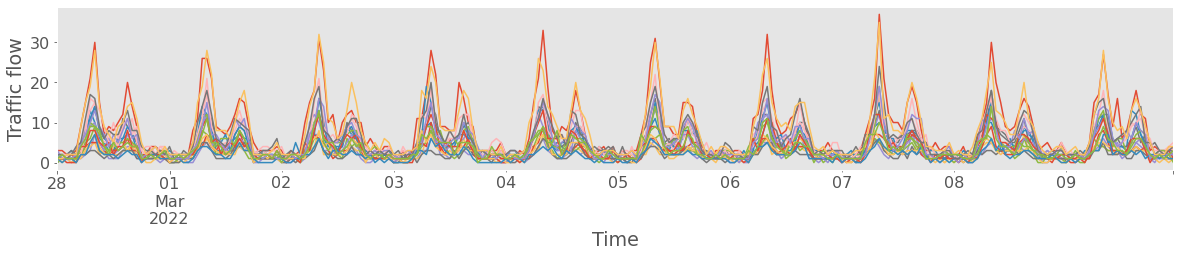

In [6]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,3)
df_re.plot(legend=None)
plt.grid()
plt.ylabel('Traffic flow')
plt.xlabel('Time')
# xlim = np.arange(0, 60* 60 *24, 60*60*4)
# plt.xticks(xlim, [str(n).zfill(2) + ':00' for n in np.arange(0, 24, 4)])

In [7]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(3, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

In [8]:
train_set = df_re['2022-02-28':'2022-03-08']
test_set = df_re['2022-03-09':'2022-03-09']

In [9]:
def SARIMA(train_data, test_data):
    # Train the model
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    AIC = []
    SARIMAX_model = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue
    parameter = [min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]]
    print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

    # Fit the model
    mod = sm.tsa.statespace.SARIMAX(train_data,
                                    order=SARIMAX_model[AIC.index(min(AIC))][0],
                                    seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

    # Prediction
    pred2 = results.get_forecast('2022-03-09 23:00:00')
    pred2_ci = pred2.conf_int()
    prediction = pred2.predicted_mean['2022-03-09 00:00:00':'2022-03-09 23:00:00'].values

    # Mean Absolute Percentage Error
    truth = test_data.values
    # MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100
    MAE = np.mean(np.abs(truth - prediction))
    print('The Mean Absolute Percentage Error for the forecast of 2022-03-09 is {:.2f}'.format(MAE))
    return parameter, prediction, MAE

In [10]:
predictions = []
MAEs = []
parameters = []
for cl in range(len(clusters)):
    train_data = train_set[cl]
    test_data = test_set[cl]
    parameter, prediction, MAE = SARIMA(train_data, test_data)
    parameters.append(parameter)
    predictions.append(prediction)
    MAEs.append(MAE)

The smallest AIC is 488.3941491853201 for model SARIMAX(3, 0, 0)x(3, 1, 0, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 1.70
The smallest AIC is 376.51002980465097 for model SARIMAX(3, 0, 0)x(3, 1, 0, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 1.22
The smallest AIC is 333.8636529751463 for model SARIMAX(3, 0, 0)x(3, 1, 0, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 0.58
The smallest AIC is 414.91646358207703 for model SARIMAX(3, 0, 1)x(3, 1, 1, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 1.27
The smallest AIC is 306.38324574042576 for model SARIMAX(3, 0, 0)x(3, 1, 0, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 0.58
The smallest AIC is 317.7422042652366 for model SARIMAX(3, 0, 0)x(3, 1, 0, 24)
The Mean Absolute Percentage Error for the forecast of 2022-03-09 is 0.72
The smallest AIC is 427.03231235117767 for model SARIMAX(3, 0, 0)x(3, 1, 1, 24)

In [11]:
sum(MAEs)/len(MAEs)

0.9701669945975485

In [12]:
flow_cl = pd.DataFrame(predictions).T.round(0).astype('int')
flow_cl.to_pickle('flow_%i.pkl'%len(clusters))

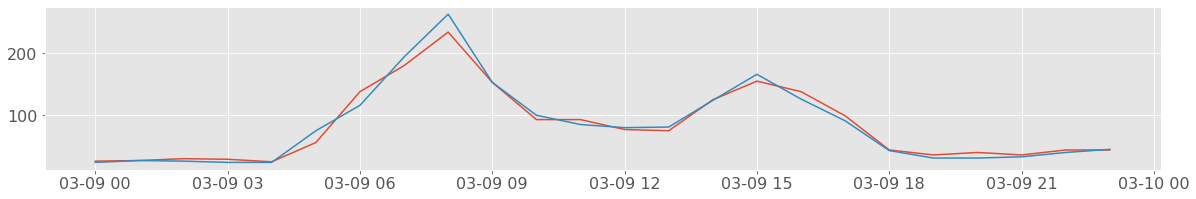

In [13]:
df3 = pd.DataFrame(df_re['2022-03-09':'2022-03-09'].T.sum())
df3[1] = pd.DataFrame(predictions).round(0).astype('int').sum().tolist()
plt.plot(df3)

In [14]:
df3['error'] = abs(df3[0]-df3[1])
df3['error'].tolist()

[2, 0, 4, 5, 1, 19, 22, 14, 29, 0, 7, 8, 3, 6, 1, 11, 12, 8, 1, 5, 9, 3, 4, 1]

In [15]:
df3['error'].mean()

7.291666666666667

In [16]:
df3['error'].std()

7.439490203821335

In [17]:
test_set.round(0).astype('int').reset_index(drop=True).to_pickle('flow_20_true.pkl')

In [18]:
pd.read_pickle('flow_20.pkl')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,2,0,2,1,0,1,1,1,1,1,1,2,1,1,0,1,2,3,1
1,3,2,1,2,1,1,2,0,1,1,1,0,2,2,1,0,2,2,2,1
2,3,2,1,2,0,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1
3,2,2,0,1,1,1,2,0,1,1,0,1,2,1,1,1,1,2,3,1
4,2,1,0,2,1,1,1,1,1,0,1,0,3,2,1,0,1,2,3,1
5,7,3,2,5,2,2,5,1,3,4,2,3,4,3,5,2,4,7,6,5
6,11,5,3,7,3,3,9,4,6,7,3,4,5,6,4,3,7,8,12,6
7,20,9,5,11,5,6,12,7,10,10,4,7,9,13,8,4,11,14,21,8
8,32,11,5,15,5,6,16,8,15,12,5,6,15,19,11,5,17,20,30,10
9,20,8,4,8,2,5,10,4,9,8,3,3,6,8,8,3,10,12,15,7


In [20]:
df_re['2022-02-28':'2022-02-28'].round(0).astype('int').reset_index(drop=True).to_pickle('flow_20_old.pkl')